# March Madness 2016 Kaggle data

In [3]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
data_dir = 'C:/Users/kesj/data/kaggle/march-machine-learning-mania-2016-v2/'

In [5]:
os.chdir(data_dir)
from glob import glob

## Start to parse the files
1. read in the regularseason compact results
2. define the list of years possible
3. pivot this to the teams (for a given year)
4. construct the various regular season features for each season

In [6]:
# helper functions

def calc_adjusted_win_losses(locations,my_class='win'):
    
    if my_class == 'win':
        multiplier = {'N':1,'A':1.4,'H':0.6}
    else:
        multiplier = {'N':1,'A':0.6,'H':1.4}
        
    adjust_count = 0
    for k,v in locations.items():
        adjust_count += v*multiplier[k]

    return adjust_count
    
def calc_win_losses(summarydf,team_id,my_season,verbose=False):
    wins = summarydf[(summarydf['Season']==my_season) & (summarydf['Wteam']==team_id)]
    loss = summarydf[(summarydf['Season']==my_season) & (summarydf['Lteam']==team_id)]
    nwins = len(wins)
    nloss = len(loss)
    # also want to count adj wins 
    # if home win: 0.6, if away win: 1.4, if neutral 1
    # if home loss: 1.4 if away loss: 0.6, if neutral 1
    win_loc = wins.Wloc.value_counts().to_dict()
    loss_loc = loss.Wloc.value_counts().to_dict()
    adj_wins = calc_adjusted_win_losses(win_loc)
    adj_loss = calc_adjusted_win_losses(loss_loc,'loss')
    if verbose:
        print("{0}-{1} adjusted to {2}-{3}".format(nwins,nloss,adj_wins,adj_loss))
    #print("adjusted")
    #print("{0}-{1}".format(adj_wins,adj_loss))
    return nwins,nloss,adj_wins,adj_loss

In [7]:
def calc_win_pct(w,l):
    wpct = w/(w+l)
    return wpct

def calc_ppg(reg_season,season,team_id,col='score'):
    #if col_attrib == 'score':
    wcol = 'W'+col
    lcol = 'L'+col
    
    wins = reg_season[(reg_season.Season==season)&(reg_season.Wteam==team_id)]
    loss = reg_season[(reg_season.Season==season)&(reg_season.Lteam==team_id)]
    win_sum = wins[wcol].sum()
    win_mean = wins[wcol].mean()
    loss_sum = loss[lcol].sum()
    loss_mean = loss[lcol].mean()
    
    opp_sum = wins[lcol].sum()+loss[wcol].sum()
    ngames = len(wins)+len(loss)
    #if col =='score':
    total_pts=win_sum+loss_sum
    ppg = total_pts/ngames
    opp_ppg = opp_sum/ngames
    return(ppg,opp_ppg)

In [8]:
def get_list_of_opponents(reg_season_df,team_id,verbose=False):
    loosing_opponents=reg_season_df[reg_season_df['Wteam']==team_id].Lteam.tolist()
    winning_opponents = reg_season_df[reg_season_df['Lteam']==team_id].Wteam.tolist()
    if verbose:
        print(loosing_opponents,winning_opponents)
    return(loosing_opponents,winning_opponents)


In [9]:
def calc_owin_pct(reg_season,teams,team_id,season_id=2015):
    lopponents,wopponents = get_list_of_opponents(reg_season[reg_season.Season==season_id],team_id)
    owins = []
    # loop through those who you beat
    for teamid in lopponents:
        #print(teamid,t2015[t2015.Team_Id==teamid][['W','L','WP']])
        try:
            w = teams[teams.Team_Id==teamid].W.values[0]
            l = teams[teams.Team_Id==teamid].L.values[0]-1 # because this oppponent lost to YOU
            owp = calc_win_pct(w,l)
            owins.append(owp)
        except IndexError:
            pass # skip over teams that aren't in that year (probably not Division 1)
    # loop through those who you lost to
    for teamid in wopponents:
        try:
            #print(teamid,t2015[t2015.Team_Id==teamid][['W','L','WP']])
            w = teams[teams.Team_Id==teamid].W.values[0]-1 # because this oppponent beat to YOU
            l = teams[teams.Team_Id==teamid].L.values[0]
            owp = calc_win_pct(w,l)
            owins.append(owp)
        except IndexErorr:
            pass 
    #print("number of opponents is {0}".format(len(lopponents)+len(wopponents)))
    #print(len(owins))
    avg_owins = np.mean(owins)
    return(avg_owins)
    
def calc_opp_owin_pct(reg_season,teams,team_id,season_id=2015):
    lopponents,wopponents = get_list_of_opponents(reg_season[reg_season.Season==season_id],team_id)
    oowins = []
    #append these two lists
    opponents = lopponents
    opponents+=wopponents
    # loop through those who you beat
    for teamid in opponents:
        #print(teamid,t2015[t2015.Team_Id==teamid][['W','L','WP']])
        try:
            owp = teams[teams.Team_Id==teamid].OWP.values[0]
            oowins.append(owp)
        except IndexError:
            pass # skip over teams that aren't in that year (probably not Division 1)
    oowpct = np.mean(oowins)
    return(oowpct)

In [10]:
def calc_rpi(wp,owp,oowp):
    fracs = [0.25,0.5,0.25] # allows you to adjust in one place
    rpi = fracs[0]*wp+fracs[1]*owp+fracs[2]*oowp
    return(rpi)

### Regular Season Compact results



In [11]:
reg_season_comp= pd.read_csv('RegularSeasonCompactResults.csv')
reg_season_comp.shape

(145289, 8)

In [12]:
season_years=reg_season_comp.Season.unique().tolist()

### Teams file

In [13]:
all_teams = pd.read_csv('Teams.csv')
all_teams.shape

(364, 2)

### helper function to get the team_id of a particualr team

In [14]:
def return_team_id(teams,team_name):
    ## some simple parsing things
    if team_name.endswith('.'):
        team_name=team_name[:-1] # reset
    try:
        tid = teams[teams.Team_Name==team_name].Team_Id.values[0]
    except IndexError:
        print("Sorry {0} not found in this listing".format(team_name))
        tid = 0
    return tid

In [15]:
#return_team_id(all_teams,'Gonzaga')

In [16]:
def yield_region_seed(tournseed,tid,season):
    #sval = 'omit'
    region_dict = {'W':1,'X':2,'Y':3,'Z':4}
    try:
        sval = tournseed[(tournseed.Season==season)&(tournseed.Team==tid)].Seed.values[0]
        region = region_dict[sval[0]]
        seed = sval[1:]
    except IndexError:
        region = 0
        seed = 'None'
        
    return (region,seed)
    

In [21]:
def construct_team_values(teams,regseason,season, verbose=True):
    #pull out for that season
    #rs= regseason[regseason['Season']==season]#.copy()
    #wteamids = set(rs.Wteam.values.tolist())
    #lteamids = set(rs.Lteam.values.tolist())
    wteamids =set(regseason[regseason.Season==season].Wteam.tolist())
    lteamids =set(regseason[regseason.Season==season].Lteam.tolist())
    teamids = list(wteamids.union(lteamids))
    if verbose:
        print("Season {0} had {1} games involving {2} unique teams."
              .format(season, len(regseason[regseason.Season==season]),len(teamids)))
        
    ## get the teams for a given season
    rs_teams = teams[teams.Team_Id.isin(teamids)].copy()
    ## loop through team ids to calcuate wins & losses
    tallies = []
    for tid in teamids:
        w,l,aw,al = calc_win_losses(regseason,tid,season)
        ppgvals = calc_ppg(regseason,season,tid)
        new_row = [tid,w,l,aw,al,ppgvals[0],ppgvals[1]]
        tallies.append(new_row)
    # merge this with rs_teams
    rs_teams=rs_teams.merge(pd.DataFrame(tallies,columns=['Team_Id','W','L','aW','aL','PPG','OppPPG']),on='Team_Id')
    ## calculate the win pct and adjusted win pct
    rs_teams['WP'] = rs_teams[['W','L']].apply(lambda x: calc_win_pct(x[0],x[1]),axis=1)#/(x[0]+x[1]),axis=1)
    rs_teams['aWP']= rs_teams[['aW','aL']].apply(lambda x: calc_win_pct(x[0],x[1]),axis=1)#/(x[0]+x[1]),axis=1)
    
    ## calculate OWP
    owp_tallies = []
    for tid in teamids:#[:10]:
        avg_owp = calc_owin_pct(regseason,rs_teams,tid,season)
        new_row = [tid,avg_owp]
        owp_tallies.append(new_row)
    
    rs_teams=rs_teams.merge(pd.DataFrame(owp_tallies, columns =['Team_Id','OWP']),on='Team_Id')
    
    ## calculate OOWP
    owp_tallies2 = []
    # add in info about if they are in the tourney (use their seed #)
    #tourney_seeding =[]
    
    for tid in teamids:
        oowpct = calc_opp_owin_pct(regseason,rs_teams,tid,season)
        new_row = [tid,oowpct]
        owp_tallies2.append(new_row)
        #reg,seed = yield_region_seed(tourney_seeds,tid,season)
        #tourney_seeding.append([tid,reg,seed])
        
    rs_teams= rs_teams.merge(pd.DataFrame(owp_tallies2,columns=['Team_Id','OOWP']),on='Team_Id')
    #rs_teams = rs_teams.merge(pd.DataFrame(tourney_seeding,columns=['Team_Id','Region','Seed']),on='Team_Id')
    
    # now calculate RPI and avg score margin
    rs_teams['RPI'] = rs_teams[['aWP','OWP','OOWP']].apply(lambda x: calc_rpi(x[0],x[1],x[2]),axis=1)
    
    # calculate avg score margin
    rs_teams['scoreMargin']=rs_teams['PPG']-rs_teams['OppPPG']

    
    return rs_teams
    

In [ ]:
#tourney_seeds = pd.read_csv('TourneySeeds.csv')
#tourney_seeds.head()

In [18]:
def get_pct(x,rseason_teams,tfeature='WP'):
    tid = x
    wp = rseason_teams[rseason_teams['Team_Id']==tid][tfeature].values[0]
    return wp

## REGIONAL alignments
* 'W' plays 'X' 
    * 'W' is first alphabeticall
* 'Y' plays 'Z'
    * "Y" is first alphabetical out of these two
    
* I'm going to map them onto ints so that W->1, X->2, Y->3, Z->4


In [22]:
rs2015 = construct_team_values(all_teams,reg_season_comp,2015)

Season 2015 had 5354 games involving 351 unique teams.


In [23]:
rs2014 = construct_team_values(all_teams,reg_season_comp,2014)

Season 2014 had 5362 games involving 351 unique teams.


In [24]:
rs2015.head()

,Team_Id,Team_Name,W,L,aW,aL,PPG,OppPPG,WP,aWP,OWP,OOWP,RPI,scoreMargin
0,1101,Abilene Chr,7,21,5.8,24.2,61.000000,71.857143,0.250000,0.193333,0.463433,0.461547,0.395437,-10.857143
1,1102,Air Force,12,17,8.8,19.4,64.724138,65.862069,0.413793,0.312057,0.486745,0.497768,0.445829,-1.137931
2,1103,Akron,20,14,15.2,16.4,67.352941,63.235294,0.588235,0.481013,0.511210,0.506309,0.502436,4.117647
3,1104,Alabama,17,14,13.8,14.8,66.645161,64.516129,0.548387,0.482517,0.559389,0.542103,0.535850,2.129032
4,1105,Alabama A&M,8,20,8.8,22.0,61.285714,68.714286,0.285714,0.285714,0.407572,0.445021,0.386470,-7.428571


In [25]:
rs2016 = construct_team_values(all_teams,reg_season_comp,2016)

Season 2016 had 5369 games involving 351 unique teams.


In [26]:
rs2013 = construct_team_values(all_teams,reg_season_comp,2013)

Season 2013 had 5320 games involving 347 unique teams.


In [27]:
rs2012 = construct_team_values(all_teams,reg_season_comp,2012)

Season 2012 had 5253 games involving 345 unique teams.


In [29]:
rs2011 = construct_team_values(all_teams, reg_season_comp,2011)

Season 2011 had 5246 games involving 345 unique teams.


In [30]:
rs2010 = construct_team_values(all_teams, reg_season_comp,2010)

Season 2010 had 5263 games involving 347 unique teams.


In [35]:
rs2010

,Team_Id,Team_Name,W,L,aW,aL,PPG,OppPPG,WP,aWP,OWP,OOWP,RPI,scoreMargin
0,1102,Air Force,8,21,5.6,21.4,55.620690,62.965517,0.275862,0.207407,0.546063,0.512075,0.452902,-7.344828
1,1103,Akron,23,10,21.0,10.0,71.030303,66.454545,0.696970,0.677419,0.492794,0.511868,0.543719,4.575758
2,1104,Alabama,17,15,13.8,15.0,68.500000,64.781250,0.531250,0.479167,0.562605,0.543998,0.537094,3.718750
3,1105,Alabama A&M,8,15,7.2,17.0,63.826087,70.304348,0.347826,0.297521,0.378100,0.438878,0.373149,-6.478261
4,1106,Alabama St,13,15,13.0,18.2,64.035714,66.428571,0.464286,0.416667,0.374679,0.450222,0.404062,-2.392857
5,1107,Albany NY,7,25,6.6,27.4,62.718750,69.125000,0.218750,0.194118,0.489261,0.465365,0.409501,-6.406250
6,1108,Alcorn St,2,29,1.2,33.0,60.645161,82.000000,0.064516,0.035088,0.452960,0.446165,0.346793,-21.354839
7,1110,American Univ,11,20,9.8,21.6,62.612903,67.193548,0.354839,0.312102,0.430755,0.469388,0.410750,-4.580645
8,1111,Appalachian St,20,11,18.4,13.4,73.258065,68.967742,0.645161,0.578616,0.484180,0.492821,0.509950,4.290323
9,1112,Arizona,16,15,13.2,15.8,71.903226,72.032258,0.516129,0.455172,0.569632,0.539481,0.533480,-0.129032


In [33]:
reg_season_list = ['rs'+np.str(year) for year in season_years[-7:]]

In [34]:
os.mkdir('derived_data')
os.chdir('derived_data')

In [36]:
rs2010.to_csv('rs2010.csv',index=False)
rs2011.to_csv('rs2011.csv',index=False)
rs2012.to_csv('rs2012.csv',index=False)
rs2013.to_csv('rs2013.csv',index=False)
rs2014.to_csv('rs2014.csv',index=False)
rs2015.to_csv('rs2015.csv',index=False)
rs2016.to_csv('rs2016.csv',index=False)

## I want to get info about the tournament victories/seeding now

In [38]:
os.chdir('../')
tourney_comp = pd.read_csv('TourneyCompactResults.csv')

In [52]:
rs2015.columns

Index(['Team_Id', 'Team_Name', 'W', 'L', 'aW', 'aL', 'PPG', 'OppPPG', 'WP',
       'aWP', 'OWP', 'OOWP', 'RPI', 'scoreMargin'],
      dtype='object')

In [54]:
def transform_tourney_games(tourney,regseason,season):
    tgames = tourney[tourney.Season==season].copy()
    tourney_teams = list(set(tgames.Wteam.tolist()).union(set(tgames.Lteam.tolist())))
    tgames['w_WP'] = tgames['Wteam'].apply(lambda x: get_pct(x,regseason))
    tgames['l_WP'] = tgames['Lteam'].apply(lambda x: get_pct(x,regseason))
    tgames['w_aWP'] = tgames['Wteam'].apply(lambda x: get_pct(x,regseason,'aWP'))#.head()
    tgames['l_aWP'] = tgames['Lteam'].apply(lambda x: get_pct(x,regseason,'aWP'))#.head()
    tgames['w_RPI'] = tgames['Wteam'].apply(lambda x: get_pct(x,regseason,'RPI'))#.head()
    tgames['l_RPI'] = tgames['Lteam'].apply(lambda x: get_pct(x,regseason,'RPI'))#.head()
    tgames['w_PPG'] = tgames['Wteam'].apply(lambda x: get_pct(x,regseason,'PPG'))
    tgames['l_PPG'] = tgames['Lteam'].apply(lambda x: get_pct(x,regseason,'PPG'))
    tgames['w_scoreMargin'] = tgames['Wteam'].apply(lambda x: get_pct(x,regseason,'scoreMargin'))
    tgames['l_scoreMargin'] = tgames['Lteam'].apply(lambda x: get_pct(x,regseason,'scoreMargin'))

    return tgames

In [55]:
tgames2015 = transform_tourney_games(tourney_comp,rs2015,2015)

In [56]:
#sns.jointplot(tgames2015['Wteam'].apply(lambda x: get_pct(x,rs2015,'PPG')).values,tgames2015['Wscore'].values)

In [59]:
tgames2015.columns

Index(['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore', 'Wloc',
       'Numot', 'w_WP', 'l_WP', 'w_aWP', 'l_aWP', 'w_RPI', 'l_RPI', 'w_PPG',
       'l_PPG', 'w_scoreMargin', 'l_scoreMargin'],
      dtype='object')

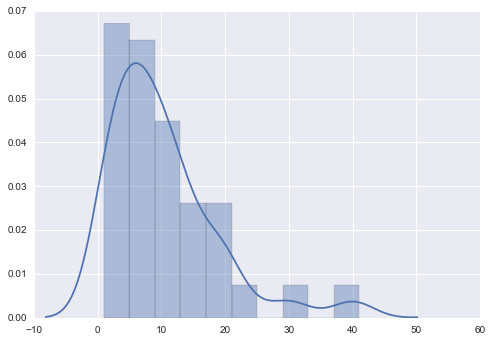

In [60]:
sns.distplot(tgames2015['Wscore']-tgames2015['Lscore'])

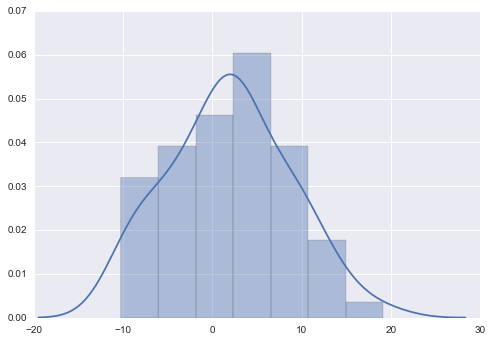

In [61]:
sns.distplot(tgames2015['w_PPG']-tgames2015['l_PPG'])

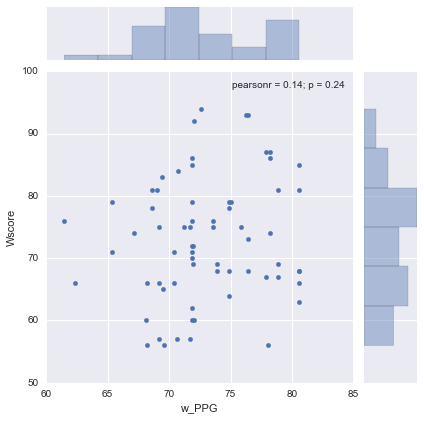

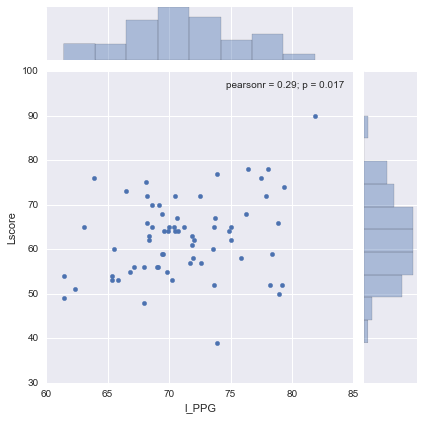

In [63]:
sns.jointplot(x='w_PPG',y='Wscore',data=tgames2015)
sns.jointplot(x='l_PPG',y='Lscore',data=tgames2015)

### RegularSeasonDetailedResults

This file is a more detailed set of game results, covering seasons 2003-2015. This includes team-level total statistics for each game (total field goals attempted, offensive rebounds, etc.) The column names should be self-explanatory to basketball fans (as above, "w" or "l" refers to the winning or losing team):

* wfgm - field goals made
* wfga - field goals attempted
* wfgm3 - three pointers made
* wfga3 - three pointers attempted
* wftm - free throws made
* wfta - free throws attempted
* wor - offensive rebounds
* wdr - defensive rebounds
* wast - assists
* wto - turnovers
* wstl - steals
* wblk - blocks
* wpf - personal fouls

In [ ]:
reg_season_dtl = pd.read_csv('RegularSeasonDetailedResults.csv')

In [ ]:
tourney_seeds.Seed.unique()

In [ ]:
sval = tourney_seeds[(tourney_seeds.Season==2014) & (tourney_seeds.Team==1277)].Seed.values[0]
sval[0], sval[1:]

In [ ]:
yield_region_seed(tourney_seeds,1112,2014), all_teams[all_teams.Team_Id==1112]

In [ ]:
tourney_comp.head()

### TourneySeeds

This file identifies the seeds for all teams in each NCAA tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on the bracket structure.

* "season" - the year
* "seed" - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tells you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have the same first three characters. For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "seasons.csv" file was the East region). This seed is also referenced in the "tourney_slots.csv" file that tells us which bracket slots face which other bracket slots in which rounds.
* "team" - this identifies the id number of the team, as specified in the teams.csv file

## now calculate the win percentage and adjusted win percentage

### TourneySlots

This file identifies the mechanism by which teams are paired against each other, depending upon their seeds. Because of the existence of play-in games for particular seed numbers, the pairings have small differences from year to year. If there were N teams in the tournament during a particular year, there were N-1 teams eliminated (leaving one champion) and therefore N-1 games played, as well as N-1 slots in the tournament bracket, and thus there will be N-1 records in this file for that season.

* "season" - the year
* "slot" - this uniquely identifies one of the tournament games. For play-in games, it is a three-character string identifying the seed fulfilled by the winning team, such as W16 or Z13. For regular tournament games, it is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.
* "strongseed" - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "strongseed", which during the 1985 tournament would have been Georgetown. Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", but those games are represented in the same format for the sake of uniformity.
* "weakseed" - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column.

## look at distribution of WP & aWP

In [ ]:
sns.distplot(t2015.WP,label='WP')
sns.distplot(t2015.aWP,label='aWP')

## load in the corresponding tournament info

In [ ]:
tourneyResults2015 = tourney_comp[tourney_comp['Season']==2015].copy()
# for each of these 67 games plot the WP for winners & loosers

In [ ]:
t2015[t2015.Team_Id==1214][['WP','aWP']].values.ravel()

In [ ]:
get_pct(1214,t2015)

In [ ]:
tourneyResults2015.head()

In [ ]:
sns.distplot(tourneyResults2015.wteamWP)
sns.distplot(tourneyResults2015.lteamWP)
plt.title('2015 tourney game outcomes regSeason WP')

In [ ]:
sns.distplot(tourneyResults2015.wteam_aWP,label='winners AWP')
sns.distplot(tourneyResults2015.lteam_aWP,label='loosers AWP')
plt.title('2015 tourney game outcomes regSeason aWP')
plt.legend()

In [ ]:
sns.regplot(x='wteam_aWP',y='wteamWP',data=tourneyResults2015)

In [ ]:
tR.values[0]

* RPI = $0.25*WP + 0.5*OWP+ 0.25*OOWP$
* OWP = opponent's winning percentage (omit games against you)
* OOWP (Opponents’ Opponents’ Winning Percentage) is the average OWP of all your opponents. OWP is exactly the number computed in the previous step.

## now calculate the OOWP

In [ ]:
sns.jointplot(x='aWP',y='OOWP',data=t2015)

## calculate RPI

In [ ]:
sns.jointplot(x='aWP',y='RPI',data=t2015)

In [ ]:
t2015.sort_values(by='RPI',ascending=False)

In [ ]:
tourney_seeds = pd.read_csv('TourneySeeds.csv')
tourney_seeds.head()

In [ ]:
tourney_teams_2015 = tourney_seeds[tourney_seeds['Season']==2015].Team.tolist()


In [ ]:
t2015['tourney'] = 0
#t2015['tourney'].iloc[t2015[t2015.Team_Id.isin(tourney_teams_2015)]
#t2015.iloc[t2015.Team_Id.isin(tourney_teams_2015),'tourney']=1
t2015.loc[t2015[t2015.Team_Id.isin(tourney_teams_2015)].index.tolist(),'tourney']=1
t2015.tourney.value_counts()

In [ ]:
sns.boxplot(x='tourney',y='RPI',data=t2015)

In [ ]:
sns.distplot(t2015[t2015.tourney==1].RPI,hist=False,label='dancing')
sns.distplot(t2015[t2015.tourney==0].RPI,hist=False,label='Not dancing')

In [ ]:
tourneyResults2015['wteam_RPI'] = tourneyResults2015['Wteam'].apply(lambda x: get_pct(x,t2015,'RPI'))#.head()
tourneyResults2015['lteam_RPI'] = tourneyResults2015['Lteam'].apply(lambda x: get_pct(x,t2015,'RPI'))#.head()

In [ ]:
sns.distplot(tourneyResults2015.wteam_RPI,label='winners RPI',hist=False)
sns.distplot(tourneyResults2015.lteam_RPI,label='loosers RPI',hist=False)
plt.title('2015 tourney game outcomes regSeason RPI')
plt.legend()

In [ ]:
tourneyResults2015.tail(10)

In [ ]:
(tourneyResults2015['wteam_RPI']-tourneyResults2015['lteam_RPI']).hist(bins=30)

In [ ]:
(tourneyResults2015['wteam_aWP']-tourneyResults2015['lteam_aWP']).hist(bins=30)

In [ ]:
t2015.sort_values(by='RPI')

In [ ]:
len(t2015)

In [ ]:
def rank_teams(teams,col='RPI'):
    teams[col+'_rank']=0
    nteams = len(teams)
    my_ranks = np.arange(nteams,0,-1)
    trank = teams[col].argsort()
    teams.loc[trank.values,col+'_rank']=my_ranks
    return teams

In [ ]:
my_ranks = np.arange(len(t2015),0,-1)
#t2015.ix[trank.values]#['RPI_my_ranks

In [ ]:
t2015['rpi_rank']=0

In [ ]:
trank = t2015.RPI.argsort()
t2015.loc[trank.values]['rpi_rank'] = my_ranks
t2015.head()

In [ ]:
t2015.loc[trank.values,'rpi_rank']=my_ranks

In [ ]:
t2015

In [ ]:
dcolors = {0:'indianred',1:'steelblue'}
plt.scatter(t2015.rpi_rank,t2015.WP,color=[dcolors[a] for a in t2015.tourney.tolist()])
plt.xlabel('RPI Rank')
plt.ylabel('WP')

## other features I might want:
* record in last 10 games
* rematches?
* margin of victory
* others from detailed season

In [ ]:
t2015.head()

In [ ]:
[name for name in t2015.Team_Name.tolist() if name.endswith('St')]

In [ ]:
return_team_id(t2015,'Michigan St.')

In [ ]:
#reg_season_comp[(reg_season_comp.Season==2016)*reg_season_comp.Wteam==1277].plot(x='Wscore',y='Lscore',kind='scatter')#.mean()
#reg_season_comp[(reg_season_comp.Season==2016)*reg_season_comp.Lteam==1277].plot(x='Wscore',y='Lscore',kind='scatter',color='indianred')#.mean()

In [ ]:
reg_season_dtl[(reg_season_dtl.Season==2016)&(reg_season_dtl.Wteam==1277)]

In [ ]:
t2015.head()

In [ ]:
sns.boxplot(x='tourney',y='PPG',data=t2015)

# calculate scoring margin

In [ ]:

sns.distplot(t2015.scoreMargin)

In [ ]:
sns.jointplot(x='RPI',y='scoreMargin',data=t2015)

In [ ]:
t2015.sort_values(by='PPG',ascending=False)

## add this to the tourney results 2015

In [ ]:
tourneyResults2015['w_scoreMarg'] = tourneyResults2015['Wteam'].apply(lambda x: get_pct(x,t2015,'scoreMargin'))#.head()
tourneyResults2015['l_scoreMarg'] = tourneyResults2015['Lteam'].apply(lambda x: get_pct(x,t2015,'scoreMargin'))#.head()

In [ ]:
sns.distplot(tourneyResults2015.w_scoreMarg,label='winners')
sns.distplot(tourneyResults2015.l_scoreMarg,label='loosers')

In [ ]:
sns.jointplot(tourneyResults2015.w_scoreMarg,tourneyResults2015.wteam_aWP)

## Question does performance against other teams in the tourney correlate with success?

## need to generate some attributes for different years and the train on them